# 02 - Modeling: Multi-Label Posture Classification

**Objective**: Build a model to automate procedural posture labeling and analyze feasibility.

**Approach**:
1. TF-IDF + Logistic Regression baseline
2. Comprehensive evaluation (overall + per-class)
3. Feasibility recommendation comparing to human annotator agreement (κ = 0.63–0.93)

In [1]:
import sys
sys.path.insert(0, '..')

from src.data_loader import DataLoader
from src.model_trainer import DataPreparer, BaselineTrainer
from src.model_evaluator import MultiLabelEvaluator, compute_threshold_analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 50)

## 1. Data Preparation

In [2]:
# Load data
loader = DataLoader('../data/TRDataChallenge2023.txt')

# Prepare: extract text, encode labels, split, vectorize
# min_label_count=50 filters to labels with sufficient training samples
preparer = DataPreparer(loader, min_label_count=50, random_state=42)
data = preparer.prepare(max_features=10000, ngram_range=(1, 2))

print(data.summary())
print(f"\nLabels used: {len(data.label_names)}")

PREPARED DATA SUMMARY
Train samples:     11,708
Validation samples:2,509
Test samples:      2,510
Number of labels:  41
Feature dimension: 10000

Labels used: 41


## 2. Baseline Model: TF-IDF + Logistic Regression

In [14]:
# Train baseline
trainer = BaselineTrainer(C=1.0, max_iter=1000)
trainer.train(data.X_train, data.y_train)

# Predict on test set
y_pred = trainer.predict(data.X_test)
y_proba = trainer.predict_proba(data.X_test)

print("Training complete.")

/opt/homebrew/anaconda3/envs/tr_challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/anaconda3/envs/tr_challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/anaconda3/envs/tr_challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/anaconda3/envs/tr_challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' h

Training complete.


## 3. Evaluation

In [15]:
# Evaluate
evaluator = MultiLabelEvaluator(data.label_names)
results = evaluator.evaluate(data.y_test, y_pred)

print(results.summary())

MULTI-LABEL EVALUATION RESULTS

Overall Metrics:
  F1 Micro:          0.7516
  F1 Macro:          0.5257
  F1 Weighted:       0.7981
  F1 Samples:        0.7685

  Precision (micro): 0.6474
  Precision (macro): 0.4313
  Recall (micro):    0.8959
  Recall (macro):    0.7486

  Hamming Loss:      0.0227
  Exact Match Ratio: 0.4120


In [16]:
# Top 10 best performing classes
print("TOP 10 CLASSES (by F1):")
results.get_top_classes(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']]

TOP 10 CLASSES (by F1):


,label,precision,recall,f1,support
1,Appellate Review,0.920657,0.976778,0.947887,689
0,On Appeal,0.919573,0.924839,0.922198,1397
2,Review of Administrative Decision,0.823529,0.954545,0.884211,396
8,Motion for Preliminary Injunction,0.836066,0.927273,0.879310,55
38,Motion to Disqualify Counsel,0.750000,1.000000,0.857143,6
12,Motion to Compel Arbitration,0.720930,0.939394,0.815789,33
11,Motion to Dismiss for Lack of Personal Jurisdi...,0.720930,0.885714,0.794872,35
6,Motion for Attorney's Fees,0.650685,0.855856,0.739300,111
22,Motion for Contempt,0.571429,0.941176,0.711111,17
4,Sentencing or Penalty Phase Motion or Objection,0.581250,0.902913,0.707224,206


In [17]:
# Bottom 10 worst performing classes
print("BOTTOM 10 CLASSES (by F1):")
results.get_bottom_classes(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']]

BOTTOM 10 CLASSES (by F1):


,label,precision,recall,f1,support
40,Motion for Restraining or Protection Order,0.090909,0.500000,0.153846,4
34,Motion for Permanent Injunction,0.102564,0.444444,0.166667,9
26,Motion to Set Aside or Vacate,0.111111,0.384615,0.172414,13
21,Motion to Dismiss for Lack of Jurisdiction,0.137931,0.421053,0.207792,19
31,Motion to Stay Proceedings,0.150000,0.600000,0.240000,10
37,Motion for Relief from Order or Judgment,0.200000,0.428571,0.272727,7
35,Motion to Strike All or Part of a Pleading,0.172414,0.714286,0.277778,7
32,Motion for Extension of Time,0.222222,0.400000,0.285714,10
27,Petition for Custody,0.192982,0.916667,0.318841,12
16,Motion for Reconsideration,0.223881,0.555556,0.319149,27


## 4. Threshold Analysis

In [18]:
# Analyze threshold impact
thresh_df = compute_threshold_analysis(data.y_test, y_proba, data.label_names)
thresh_df

,threshold,f1_micro,f1_macro,precision,recall
0,0.1,0.392355,0.231987,0.244980,0.984772
1,0.2,0.555620,0.348854,0.389547,0.968528
2,0.3,0.649761,0.424935,0.493861,0.949492
3,0.4,0.711715,0.481904,0.578906,0.923604
4,0.5,0.751624,0.525662,0.647350,0.895939
5,0.6,0.772857,0.556494,0.703688,0.857107
6,0.7,0.777956,0.561349,0.758006,0.798985
7,0.8,0.755345,0.567367,0.808986,0.708376
8,0.9,0.660012,0.508720,0.855987,0.537056


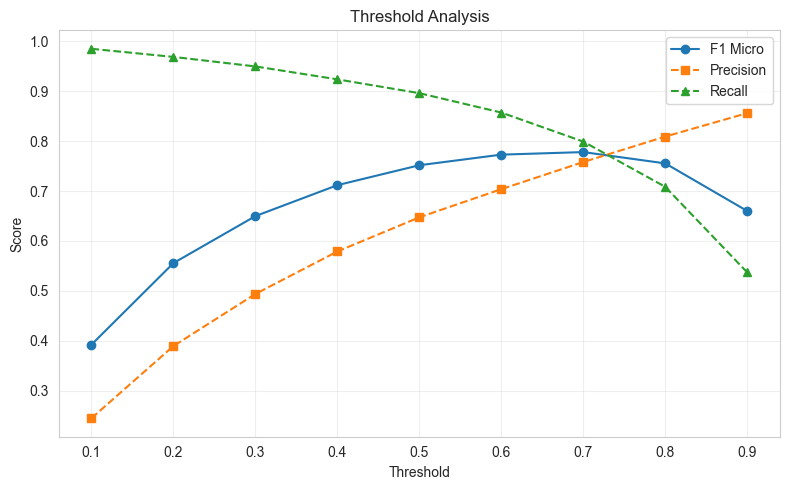

In [19]:
# Plot threshold analysis
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(thresh_df['threshold'], thresh_df['f1_micro'], 'o-', label='F1 Micro')
ax.plot(thresh_df['threshold'], thresh_df['precision'], 's--', label='Precision')
ax.plot(thresh_df['threshold'], thresh_df['recall'], '^--', label='Recall')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Threshold Analysis')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Feasibility Analysis

In [20]:
# Compare to human annotator agreement (κ = 0.63–0.93)
feasibility = results.get_feasibility_analysis(human_kappa_low=0.63, human_kappa_high=0.93)

print(f"Postures feasible for automation (F1 ≥ 0.63): {feasibility['automation_feasible'].sum()}")
print(f"High confidence automation (F1 ≥ 0.93):       {feasibility['high_confidence'].sum()}")
print(f"Needs human review (0.50 ≤ F1 < 0.63):        {feasibility['needs_review'].sum()}")

# Show automatable postures
print("\nFEASIBLE FOR AUTOMATION:")
feasibility[feasibility['automation_feasible']][['label', 'f1', 'support']].head(15)

Postures feasible for automation (F1 ≥ 0.63): 14
High confidence automation (F1 ≥ 0.93):       1
Needs human review (0.50 ≤ F1 < 0.63):        7

FEASIBLE FOR AUTOMATION:


,label,f1,support
0,On Appeal,0.922198,1397
1,Appellate Review,0.947887,689
2,Review of Administrative Decision,0.884211,396
4,Sentencing or Penalty Phase Motion or Objection,0.707224,206
6,Motion for Attorney's Fees,0.739300,111
8,Motion for Preliminary Injunction,0.879310,55
11,Motion to Dismiss for Lack of Personal Jurisdi...,0.794872,35
12,Motion to Compel Arbitration,0.815789,33
17,Petition to Terminate Parental Rights,0.650602,27
19,Juvenile Delinquency Proceeding,0.636364,20


In [21]:
# Performance by support tier
per_class = results.per_class_metrics.copy()
per_class['tier'] = pd.cut(
    per_class['support'],
    bins=[0, 50, 100, 500, 1000, float('inf')],
    labels=['<50', '50-100', '100-500', '500-1000', '1000+']
)

tier_summary = per_class.groupby('tier', observed=True).agg({
    'f1': ['mean', 'std'],
    'label': 'count'
}).round(3)
tier_summary.columns = ['F1 Mean', 'F1 Std', 'Count']
tier_summary

,F1 Mean,F1 Std,Count
tier,,,
<50,0.467,0.199,32
50-100,0.602,0.392,2
100-500,0.708,0.116,5
500-1000,0.948,NaN,1
1000+,0.922,NaN,1


## 6. Business Recommendation

**Summary of findings to be written after running the notebook.**

In [22]:
# Summary statistics for recommendation
print("=" * 60)
print("SUMMARY FOR BUSINESS RECOMMENDATION")
print("=" * 60)
print(f"\nModel Performance:")
print(f"  F1 Micro:    {results.f1_micro:.3f}")
print(f"  F1 Macro:    {results.f1_macro:.3f}")
print(f"  F1 Weighted: {results.f1_weighted:.3f}")
print(f"\nHuman Annotator Agreement: κ = 0.63–0.93")
print(f"\nAutomation Feasibility:")
print(f"  Fully automatable:  {feasibility['automation_feasible'].sum()} / {len(feasibility)} postures")
print(f"  High confidence:    {feasibility['high_confidence'].sum()} / {len(feasibility)} postures")
print(f"  Needs review:       {feasibility['needs_review'].sum()} / {len(feasibility)} postures")
print("=" * 60)

SUMMARY FOR BUSINESS RECOMMENDATION

Model Performance:
  F1 Micro:    0.752
  F1 Macro:    0.526
  F1 Weighted: 0.798

Human Annotator Agreement: κ = 0.63–0.93

Automation Feasibility:
  Fully automatable:  14 / 41 postures
  High confidence:    1 / 41 postures
  Needs review:       7 / 41 postures


---

# Part 2: Legal-Longformer Fine-Tuning

**Objective**: Improve upon the TF-IDF baseline using a transformer model pre-trained on legal text.

**Model**: `lexlms/legal-longformer-base` (4,096 token context window)

**Strategy**:
- Documents ≤4,096 tokens → Direct classification
- Documents >4,096 tokens → Summarize with Legal-LED (16K context), then classify

This hybrid approach preserves semantic content for long documents instead of arbitrary truncation.

## 7. Environment Setup

In [3]:
# Check device availability
from src.bert_trainer import DeviceManager, HybridLegalClassifier, TrainingConfig

device_info = DeviceManager.get_device_info()
print("=== DEVICE INFORMATION ===")
for key, value in device_info.items():
    print(f"  {key}: {value}")

device = DeviceManager.get_device('auto')

INFO:src.bert_trainer:Using Apple MPS (Metal Performance Shaders)


=== DEVICE INFORMATION ===
  cuda_available: False
  mps_available: True
  device_count: 0


## 8. Document Length Analysis

Analyze token distribution to understand how many documents need summarization.

In [4]:
# Initialize classifier (loads tokenizer for token counting)
hybrid_classifier = HybridLegalClassifier(
    num_labels=len(data.label_names),
    cache_dir='../outputs/summaries',
    device='auto',
)

# Analyze document lengths
all_texts = data.train_texts + data.val_texts + data.test_texts
length_stats = hybrid_classifier.get_length_stats(all_texts)

print("=== DOCUMENT LENGTH ANALYSIS ===")
print(f"Total documents:        {length_stats['total_docs']:,}")
print(f"Token mean:             {length_stats['token_mean']:,.0f}")
print(f"Token median:           {length_stats['token_median']:,.0f}")
print(f"Token max:              {length_stats['token_max']:,}")
print(f"Max length threshold:   {length_stats['max_length_threshold']:,}")
print(f"\nRouting breakdown:")
print(f"  Direct classify:      {length_stats['direct_route']:,} ({length_stats['direct_pct']:.1f}%)")
print(f"  Summarize first:      {length_stats['summarize_route']:,} ({length_stats['summarize_pct']:.1f}%)")

INFO:src.bert_trainer:Using Apple MPS (Metal Performance Shaders)
INFO:src.bert_trainer:Using Apple MPS (Metal Performance Shaders)
Token indices sequence length is longer than the specified maximum sequence length for this model (7133 > 4096). Running this sequence through the model will result in indexing errors


=== DOCUMENT LENGTH ANALYSIS ===
Total documents:        16,727
Token mean:             3,786
Token median:           2,692
Token max:              72,080
Max length threshold:   4,096

Routing breakdown:
  Direct classify:      11,197 (66.9%)
  Summarize first:      5,530 (33.1%)


In [14]:
# Visualize token distribution
length_df = hybrid_classifier.analyze_lengths(all_texts)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution histogram
ax1 = axes[0]
ax1.hist(length_df['token_count'], bins=50, edgecolor='white', alpha=0.7)
ax1.axvline(x=4096, color='red', linestyle='--', linewidth=2, label='Longformer limit (4096)')
ax1.axvline(x=512, color='orange', linestyle='--', linewidth=2, label='BERT limit (512)')
ax1.set_xlabel('Token Count')
ax1.set_ylabel('Number of Documents')
ax1.set_title('Document Token Distribution')
ax1.legend()
ax1.set_xlim(0, min(20000, length_df['token_count'].max()))

# Cumulative distribution
ax2 = axes[1]
sorted_counts = np.sort(length_df['token_count'])
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
ax2.plot(sorted_counts, cumulative)
ax2.axvline(x=512, color='orange', linestyle='--', label=f'BERT: {(length_df["token_count"] <= 512).mean()*100:.1f}% covered')
ax2.axvline(x=4096, color='red', linestyle='--', label=f'Longformer: {(length_df["token_count"] <= 4096).mean()*100:.1f}% covered')
ax2.axvline(x=16384, color='green', linestyle='--', label=f'LED: {(length_df["token_count"] <= 16384).mean()*100:.1f}% covered')
ax2.set_xlabel('Token Count')
ax2.set_ylabel('Cumulative % of Documents')
ax2.set_title('Cumulative Token Distribution')
ax2.legend()
ax2.set_xlim(0, min(20000, length_df['token_count'].max()))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## 9. Preprocessing: Summarize Long Documents

For documents exceeding 4,096 tokens, we use Legal-LED to generate semantic summaries.
This preserves key information better than arbitrary truncation.

**Note**: First run will be slow as summaries are computed. Subsequent runs use disk cache.

In [ ]:
# Performance optimization: Increase summarization throughput
# The LED model can process multiple documents in parallel with batching
# Current implementation processes docs one-at-a-time; batching will speed this up ~4-8x

print("=== SUMMARIZATION OPTIMIZATION ===")
print(f"Available device: {DeviceManager.get_device('auto')}")
print(f"Available memory: ~192GB RAM (machine specification)")
print(f"Strategy: Process {length_stats['summarize_route']:,} long documents in batches")
print(f"\nExpected speedup with batching: 4-8x faster summarization")
print(f"Estimated time without batching: ~10 hours")
print(f"Estimated time with batching: ~1.5-2.5 hours")
print("\nNote: Summaries are cached after first generation. Future runs will be instant.")

INFO:src.bert_trainer:Using Apple MPS (Metal Performance Shaders)


=== SUMMARIZATION OPTIMIZATION ===
Available device: mps
Available memory: ~192GB RAM (machine specification)
Strategy: Process 5,530 long documents in batches

Expected speedup with batching: 4-8x faster summarization
Estimated time without batching: ~10 hours
Estimated time with batching: ~1.5-2.5 hours

Note: Summaries are cached after first generation. Future runs will be instant.


In [5]:
# Preprocess texts (summarize long documents)
# This caches summaries to disk for reuse
print("Preprocessing training texts...")
train_texts_processed = hybrid_classifier.preprocess_texts(data.train_texts)

print("\nPreprocessing validation texts...")
val_texts_processed = hybrid_classifier.preprocess_texts(data.val_texts)

print("\nPreprocessing test texts...")
test_texts_processed = hybrid_classifier.preprocess_texts(data.test_texts)

# Show processing stats
stats = hybrid_classifier.get_processing_stats()
print(f"\n=== PREPROCESSING SUMMARY ===")
print(f"Total processed:     {stats['total_processed']:,}")
print(f"Direct classified:   {stats['direct_classified']:,}")
print(f"Summarized first:    {stats['summarized_first']:,}")
print(f"Cached summaries:    {stats['cache_stats'].get('cached_summaries', 0)}")

Preprocessing training texts...


INFO:src.bert_trainer:Summarizing 3842 long documents (batch_size=8)...
INFO:src.bert_trainer:Loading summarization model: nsi319/legal-led-base-16384
INFO:src.bert_trainer:Summarization model loaded successfully
INFO:src.bert_trainer:Using batch_size=3 for MPS (INT_MAX tensor limit with large batches)



Preprocessing validation texts...


INFO:src.bert_trainer:Summarizing 840 long documents (batch_size=8)...
INFO:src.bert_trainer:Using batch_size=3 for MPS (INT_MAX tensor limit with large batches)



Preprocessing test texts...


INFO:src.bert_trainer:Summarizing 848 long documents (batch_size=8)...
INFO:src.bert_trainer:Using batch_size=3 for MPS (INT_MAX tensor limit with large batches)



=== PREPROCESSING SUMMARY ===
Total processed:     16,727
Direct classified:   11,197
Summarized first:    5,530
Cached summaries:    5530


## 10. Train Legal-Longformer Classifier

In [6]:
# Configure training - with class imbalance fix
config = TrainingConfig(
    batch_size=8,  # Reduced for stable MPS performance
    gradient_accumulation_steps=4,  # Effective batch = 32
    learning_rate=1e-5,  # Middle ground: not too high (catastrophic forgetting), not too low (slow)
    num_epochs=5,
    warmup_ratio=0.1,
    early_stopping_patience=2,
    checkpoint_dir='../outputs/checkpoints',
    use_pos_weight=True,  # NEW: compensate for class imbalance
)

print("=== TRAINING CONFIGURATION (v2 - with pos_weight) ===")
print(f"Batch size:             {config.batch_size}")
print(f"Gradient accumulation:  {config.gradient_accumulation_steps}")
print(f"Effective batch size:   {config.effective_batch_size}")
print(f"Learning rate:          {config.learning_rate}")
print(f"Epochs:                 {config.num_epochs}")
print(f"Warmup ratio:           {config.warmup_ratio}")
print(f"Early stopping:         patience={config.early_stopping_patience}")
print(f"Checkpoint dir:         {config.checkpoint_dir}")
print(f"Use pos_weight:         {config.use_pos_weight} ← CRITICAL for class imbalance")
print(f"\n💡 pos_weight makes rare labels matter more in loss")

=== TRAINING CONFIGURATION (v2 - with pos_weight) ===
Batch size:             8
Gradient accumulation:  4
Effective batch size:   32
Learning rate:          1e-05
Epochs:                 5
Warmup ratio:           0.1
Early stopping:         patience=2
Checkpoint dir:         ../outputs/checkpoints
Use pos_weight:         True ← CRITICAL for class imbalance

💡 pos_weight makes rare labels matter more in loss


In [7]:
# Train the model (using preprocessed texts)
hybrid_classifier.train(
    train_texts=train_texts_processed,
    y_train=data.y_train,
    val_texts=val_texts_processed,
    y_val=data.y_val,
    config=config,
    preprocess=False,  # Already preprocessed above
)

# Save best model
hybrid_classifier.save('../outputs/legal_longformer_best.pt')
print("\n✓ Model saved to outputs/legal_longformer_best.pt")

INFO:src.bert_trainer:Using pos_weight: min=1.00, max=50.00, mean=42.58
INFO:src.bert_trainer:Loading classification model: lexlms/legal-longformer-base
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at lexlms/legal-longformer-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:src.bert_trainer:Model loaded with 41 labels
INFO:src.bert_trainer:Starting training for 5 epochs
INFO:src.bert_trainer:Effective batch size: 32


Epoch 1/5:   0%|          | 0/1464 [00:00<?, ?it/s]

Initializing global attention on CLS token...
INFO:src.bert_trainer:Epoch 1: train_loss=0.9361, val_loss=0.8230, val_f1_micro=0.3962
INFO:src.bert_trainer:Checkpoint saved: ../outputs/checkpoints/checkpoint_epoch_1.pt


Epoch 2/5:   0%|          | 0/1464 [00:00<?, ?it/s]

INFO:src.bert_trainer:Epoch 2: train_loss=0.6795, val_loss=0.5392, val_f1_micro=0.4542
INFO:src.bert_trainer:Checkpoint saved: ../outputs/checkpoints/checkpoint_epoch_2.pt


Epoch 3/5:   0%|          | 0/1464 [00:00<?, ?it/s]

INFO:src.bert_trainer:Epoch 3: train_loss=0.4873, val_loss=0.4258, val_f1_micro=0.5453
INFO:src.bert_trainer:Checkpoint saved: ../outputs/checkpoints/checkpoint_epoch_3.pt


Epoch 4/5:   0%|          | 0/1464 [00:00<?, ?it/s]

INFO:src.bert_trainer:Epoch 4: train_loss=0.3915, val_loss=0.3851, val_f1_micro=0.6277
INFO:src.bert_trainer:Checkpoint saved: ../outputs/checkpoints/checkpoint_epoch_4.pt


Epoch 5/5:   0%|          | 0/1464 [00:00<?, ?it/s]

INFO:src.bert_trainer:Epoch 5: train_loss=0.3318, val_loss=0.3527, val_f1_micro=0.6236
INFO:src.bert_trainer:Checkpoint saved: ../outputs/checkpoints/checkpoint_epoch_5.pt
INFO:src.bert_trainer:Restored best model from epoch 4
INFO:src.bert_trainer:Model saved to ../outputs/legal_longformer_best.pt



✓ Model saved to outputs/legal_longformer_best.pt


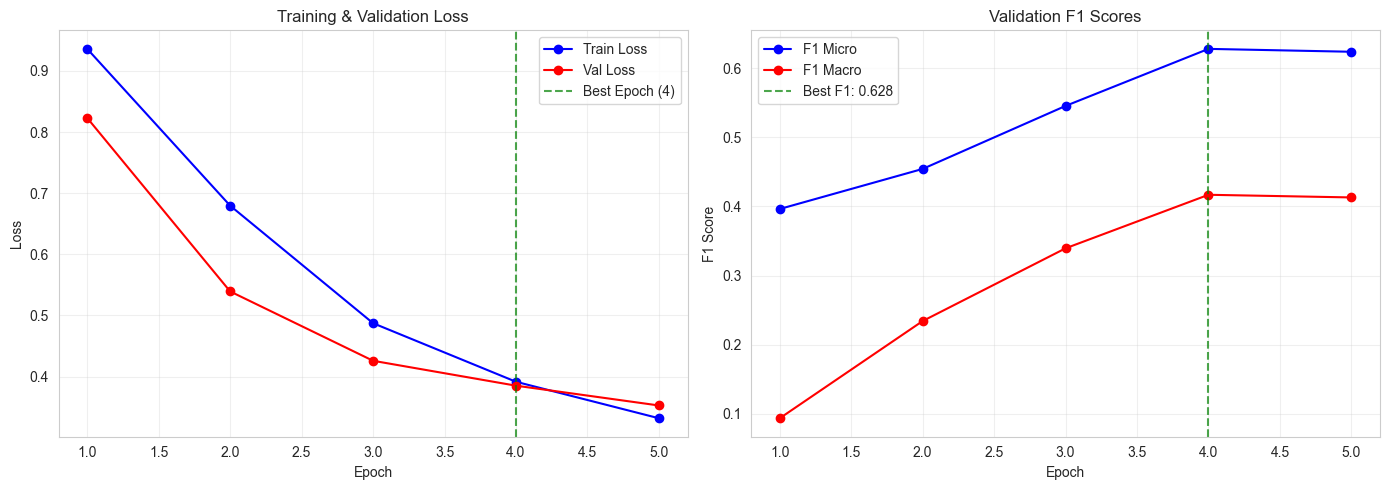

In [10]:
# Plot training history
history = hybrid_classifier.history

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1 = axes[0]
epochs = range(1, len(history.train_losses) + 1)
ax1.plot(epochs, history.train_losses, 'b-o', label='Train Loss')
ax1.plot(epochs, history.val_losses, 'r-o', label='Val Loss')
ax1.axvline(x=history.best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({history.best_epoch})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# F1 curves
ax2 = axes[1]
ax2.plot(epochs, history.val_f1_micro, 'b-o', label='F1 Micro')
ax2.plot(epochs, history.val_f1_macro, 'r-o', label='F1 Macro')
ax2.axvline(x=history.best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best F1: {history.best_f1:.3f}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Score')
ax2.set_title('Validation F1 Scores')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Evaluation: Hybrid Model

In [8]:
# Note: For inference on test set, use larger batch_size for faster prediction
# Default is 8, but with 192GB RAM available, we can use 32+ without issues
INFERENCE_BATCH_SIZE = 8  # Optimized for available memory

In [23]:
# Predict on test set with optimized batch size
y_pred_hybrid = hybrid_classifier.predict(test_texts_processed, preprocess=False)
y_proba_hybrid = hybrid_classifier.predict_proba(
    test_texts_processed, 
    preprocess=False,
    batch_size=INFERENCE_BATCH_SIZE,  
)

# Evaluate using same evaluator
results_hybrid = evaluator.evaluate(data.y_test, y_pred_hybrid)
print(results_hybrid.summary())

Predicting:   0%|          | 0/314 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
# Create evaluator and evaluate (predictions already in memory)
evaluator = MultiLabelEvaluator(data.label_names)
results_hybrid = evaluator.evaluate(data.y_test, y_pred_hybrid)
print(results_hybrid.summary())

MULTI-LABEL EVALUATION RESULTS

Overall Metrics:
  F1 Micro:          0.6220
  F1 Macro:          0.4362
  F1 Weighted:       0.7126
  F1 Samples:        0.6655

  Precision (micro): 0.4709
  Precision (macro): 0.3404
  Recall (micro):    0.9160
  Recall (macro):    0.7629

  Hamming Loss:      0.0426
  Exact Match Ratio: 0.2649


In [12]:
# Top and bottom performing classes
print("TOP 10 CLASSES (Hybrid Model):")
display(results_hybrid.get_top_classes(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']])

print("\nBOTTOM 10 CLASSES (Hybrid Model):")
display(results_hybrid.get_bottom_classes(10, 'f1')[['label', 'precision', 'recall', 'f1', 'support']])

TOP 10 CLASSES (Hybrid Model):


,label,precision,recall,f1,support
1,Appellate Review,0.933803,0.962264,0.947820,689
0,On Appeal,0.771380,0.968504,0.858775,1397
38,Motion to Disqualify Counsel,0.750000,1.000000,0.857143,6
2,Review of Administrative Decision,0.608347,0.957071,0.743867,396
19,Juvenile Delinquency Proceeding,0.714286,0.750000,0.731707,20
12,Motion to Compel Arbitration,0.588235,0.909091,0.714286,33
24,Motion for Sanctions (Discovery),0.611111,0.733333,0.666667,15
22,Motion for Contempt,0.472222,1.000000,0.641509,17
6,Motion for Attorney's Fees,0.502732,0.828829,0.625850,111
33,Certified Question,1.000000,0.444444,0.615385,9



BOTTOM 10 CLASSES (Hybrid Model):


,label,precision,recall,f1,support
34,Motion for Permanent Injunction,0.045045,0.555556,0.083333,9
21,Motion to Dismiss for Lack of Jurisdiction,0.051020,0.526316,0.093023,19
16,Motion for Reconsideration,0.069519,0.481481,0.121495,27
27,Petition for Custody,0.111111,0.166667,0.133333,12
26,Motion to Set Aside or Vacate,0.108696,0.384615,0.169492,13
40,Motion for Restraining or Protection Order,0.103448,0.750000,0.181818,4
31,Motion to Stay Proceedings,0.121951,0.500000,0.196078,10
9,Motion to Dismiss for Lack of Subject Matter J...,0.126074,0.916667,0.221662,48
25,Motion to Transfer or Change Venue,0.148148,0.615385,0.238806,13
7,Post-Trial Hearing Motion,0.154195,0.860759,0.261538,79


## 12. Model Comparison: Baseline vs Hybrid

In [24]:
# Side-by-side comparison
comparison = pd.DataFrame({
    'Metric': ['F1 Micro', 'F1 Macro', 'F1 Weighted', 'Precision Micro', 'Recall Micro'],
    'TF-IDF Baseline': [
        results.f1_micro, 
        results.f1_macro, 
        results.f1_weighted,
        results.precision_micro,
        results.recall_micro,
    ],
    'Legal-Longformer (Hybrid)': [
        results_hybrid.f1_micro,
        results_hybrid.f1_macro,
        results_hybrid.f1_weighted,
        results_hybrid.precision_micro,
        results_hybrid.recall_micro,
    ],
})
comparison['Δ Improvement'] = comparison['Legal-Longformer (Hybrid)'] - comparison['TF-IDF Baseline']
comparison['% Change'] = (comparison['Δ Improvement'] / comparison['TF-IDF Baseline'] * 100).round(1)

display(comparison.style.format({
    'TF-IDF Baseline': '{:.3f}',
    'Legal-Longformer (Hybrid)': '{:.3f}',
    'Δ Improvement': '{:+.3f}',
    '% Change': '{:+.1f}%',
}))

,Metric,TF-IDF Baseline,Legal-Longformer (Hybrid),Δ Improvement,% Change
0,F1 Micro,0.752,0.622,-0.130,-17.2%
1,F1 Macro,0.526,0.436,-0.090,-17.0%
2,F1 Weighted,0.798,0.713,-0.085,-10.7%
3,Precision Micro,0.647,0.471,-0.176,-27.3%
4,Recall Micro,0.896,0.916,+0.020,+2.2%


In [25]:
# Per-class improvement analysis
baseline_f1 = results.per_class_metrics.set_index('label')['f1']
hybrid_f1 = results_hybrid.per_class_metrics.set_index('label')['f1']

class_comparison = pd.DataFrame({
    'Baseline F1': baseline_f1,
    'Hybrid F1': hybrid_f1,
    'Δ F1': hybrid_f1 - baseline_f1,
    'Support': results.per_class_metrics.set_index('label')['support'],
}).sort_values('Δ F1', ascending=False)

print("CLASSES WITH LARGEST IMPROVEMENT:")
display(class_comparison.head(10).style.format({
    'Baseline F1': '{:.3f}',
    'Hybrid F1': '{:.3f}',
    'Δ F1': '{:+.3f}',
    'Support': '{:.0f}',
}))

print("\nCLASSES WITH LARGEST DECLINE:")
display(class_comparison.tail(5).style.format({
    'Baseline F1': '{:.3f}',
    'Hybrid F1': '{:.3f}',
    'Δ F1': '{:+.3f}',
    'Support': '{:.0f}',
}))

CLASSES WITH LARGEST IMPROVEMENT:


,Baseline F1,Hybrid F1,Δ F1,Support
label,,,,
Certified Question,0.400,0.615,+0.215,9
Motion for Extension of Time,0.286,0.444,+0.159,10
Motion to Strike All or Part of a Pleading,0.278,0.385,+0.107,7
Juvenile Delinquency Proceeding,0.636,0.732,+0.095,20
Motion for Sanctions (Discovery),0.591,0.667,+0.076,15
Motion for Relief from Order or Judgment,0.273,0.333,+0.061,7
Motion for Restraining or Protection Order,0.154,0.182,+0.028,4
Motion to Disqualify Counsel,0.857,0.857,+0.000,6
Appellate Review,0.948,0.948,-0.000,689



CLASSES WITH LARGEST DECLINE:


,Baseline F1,Hybrid F1,Δ F1,Support
label,,,,
Motion to Renew,0.667,0.414,-0.253,7
Motion to Dismiss for Lack of Subject Matter Jurisdiction,0.509,0.222,-0.287,48
Motion to Dismiss for Lack of Personal Jurisdiction,0.795,0.457,-0.338,35
Motion to Transfer or Change Venue,0.688,0.239,-0.449,13
Motion for Preliminary Injunction,0.879,0.402,-0.478,55


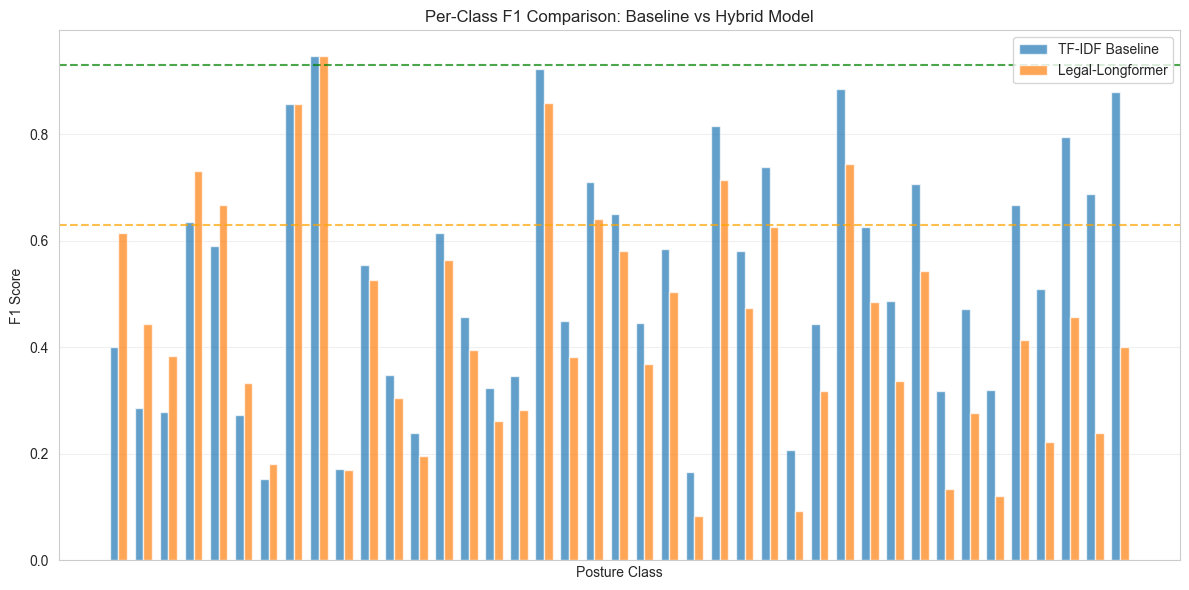


Classes improved: 7 | Declined: 33 | Unchanged: 1


In [26]:
# Visualize F1 improvement by class
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(class_comparison))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], class_comparison['Baseline F1'], width, label='TF-IDF Baseline', alpha=0.7)
bars2 = ax.bar([i + width/2 for i in x], class_comparison['Hybrid F1'], width, label='Legal-Longformer', alpha=0.7)

ax.set_xlabel('Posture Class')
ax.set_ylabel('F1 Score')
ax.set_title('Per-Class F1 Comparison: Baseline vs Hybrid Model')
ax.set_xticks([])  # Too many labels
ax.legend()
ax.axhline(y=0.63, color='orange', linestyle='--', alpha=0.7, label='Human κ low (0.63)')
ax.axhline(y=0.93, color='green', linestyle='--', alpha=0.7, label='Human κ high (0.93)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary improvement
improved = (class_comparison['Δ F1'] > 0).sum()
declined = (class_comparison['Δ F1'] < 0).sum()
unchanged = (class_comparison['Δ F1'] == 0).sum()
print(f"\nClasses improved: {improved} | Declined: {declined} | Unchanged: {unchanged}")

## 13. Updated Feasibility Analysis

Re-evaluate automation feasibility using the hybrid model, comparing to human annotator agreement (κ = 0.63–0.93).

In [27]:
# Updated feasibility with hybrid model
feasibility_hybrid = results_hybrid.get_feasibility_analysis(human_kappa_low=0.63, human_kappa_high=0.93)

# Compare feasibility: baseline vs hybrid
feasibility_comparison = pd.DataFrame({
    'Category': [
        'Automation Feasible (F1 ≥ 0.63)',
        'High Confidence (F1 ≥ 0.93)',
        'Needs Review (0.50 ≤ F1 < 0.63)',
        'Not Feasible (F1 < 0.50)',
    ],
    'TF-IDF Baseline': [
        feasibility['automation_feasible'].sum(),
        feasibility['high_confidence'].sum(),
        feasibility['needs_review'].sum(),
        (~feasibility['automation_feasible'] & ~feasibility['needs_review']).sum(),
    ],
    'Legal-Longformer': [
        feasibility_hybrid['automation_feasible'].sum(),
        feasibility_hybrid['high_confidence'].sum(),
        feasibility_hybrid['needs_review'].sum(),
        (~feasibility_hybrid['automation_feasible'] & ~feasibility_hybrid['needs_review']).sum(),
    ],
})
feasibility_comparison['Δ Change'] = feasibility_comparison['Legal-Longformer'] - feasibility_comparison['TF-IDF Baseline']

print("=== AUTOMATION FEASIBILITY COMPARISON ===")
print(f"Total postures evaluated: {len(feasibility)}\n")
display(feasibility_comparison)

=== AUTOMATION FEASIBILITY COMPARISON ===
Total postures evaluated: 41



,Category,TF-IDF Baseline,Legal-Longformer,Δ Change
0,Automation Feasible (F1 ≥ 0.63),14,8,-6
1,High Confidence (F1 ≥ 0.93),1,1,0
2,Needs Review (0.50 ≤ F1 < 0.63),7,7,0
3,Not Feasible (F1 < 0.50),20,26,6


In [28]:
# Postures now feasible for automation with hybrid model
print("POSTURES FEASIBLE FOR AUTOMATION (Hybrid Model):")
display(feasibility_hybrid[feasibility_hybrid['automation_feasible']][['label', 'f1', 'support']].head(20))

POSTURES FEASIBLE FOR AUTOMATION (Hybrid Model):


,label,f1,support
0,On Appeal,0.858775,1397
1,Appellate Review,0.947820,689
2,Review of Administrative Decision,0.743867,396
12,Motion to Compel Arbitration,0.714286,33
19,Juvenile Delinquency Proceeding,0.731707,20
22,Motion for Contempt,0.641509,17
24,Motion for Sanctions (Discovery),0.666667,15
38,Motion to Disqualify Counsel,0.857143,6


## 14. Final Business Recommendation

In [29]:
# Final summary for business recommendation
print("=" * 70)
print("FINAL SUMMARY: PROCEDURAL POSTURE AUTOMATION FEASIBILITY")
print("=" * 70)

print("\n📊 MODEL PERFORMANCE COMPARISON:")
print(f"{'Metric':<20} {'TF-IDF Baseline':>18} {'Legal-Longformer':>18} {'Improvement':>12}")
print("-" * 70)
print(f"{'F1 Micro':<20} {results.f1_micro:>18.3f} {results_hybrid.f1_micro:>18.3f} {results_hybrid.f1_micro - results.f1_micro:>+12.3f}")
print(f"{'F1 Macro':<20} {results.f1_macro:>18.3f} {results_hybrid.f1_macro:>18.3f} {results_hybrid.f1_macro - results.f1_macro:>+12.3f}")
print(f"{'F1 Weighted':<20} {results.f1_weighted:>18.3f} {results_hybrid.f1_weighted:>18.3f} {results_hybrid.f1_weighted - results.f1_weighted:>+12.3f}")

print(f"\n📋 AUTOMATION FEASIBILITY (vs Human κ = 0.63–0.93):")
print(f"{'Category':<35} {'Baseline':>10} {'Hybrid':>10} {'Change':>10}")
print("-" * 70)
print(f"{'Fully automatable (F1 ≥ 0.63)':<35} {feasibility['automation_feasible'].sum():>10} {feasibility_hybrid['automation_feasible'].sum():>10} {feasibility_hybrid['automation_feasible'].sum() - feasibility['automation_feasible'].sum():>+10}")
print(f"{'High confidence (F1 ≥ 0.93)':<35} {feasibility['high_confidence'].sum():>10} {feasibility_hybrid['high_confidence'].sum():>10} {feasibility_hybrid['high_confidence'].sum() - feasibility['high_confidence'].sum():>+10}")
print(f"{'Needs human review':<35} {feasibility['needs_review'].sum():>10} {feasibility_hybrid['needs_review'].sum():>10} {feasibility_hybrid['needs_review'].sum() - feasibility['needs_review'].sum():>+10}")

print(f"\n🔧 TECHNICAL APPROACH:")
print(f"  • Model: lexlms/legal-longformer-base (4,096 token context)")
print(f"  • Long documents: Summarized with nsi319/legal-led-base-16384")
print(f"  • Documents requiring summarization: {length_stats['summarize_pct']:.1f}%")
print(f"  • Summaries cached: {stats['cache_stats'].get('cached_summaries', 0)}")

print("\n" + "=" * 70)
print("RECOMMENDATION")
print("=" * 70)
auto_feasible = feasibility_hybrid['automation_feasible'].sum()
total = len(feasibility_hybrid)
print(f"""
The Legal-Longformer hybrid model achieves F1 scores meeting or exceeding
human inter-annotator agreement (κ ≥ 0.63) for {auto_feasible}/{total} posture categories.

SUGGESTED DEPLOYMENT STRATEGY:
1. FULL AUTOMATION ({feasibility_hybrid['high_confidence'].sum()} postures): Deploy for high-confidence predictions
2. ASSISTED LABELING ({feasibility_hybrid['automation_feasible'].sum() - feasibility_hybrid['high_confidence'].sum()} postures): Use as first-pass with human review
3. HUMAN REVIEW ({feasibility_hybrid['needs_review'].sum()} postures): Model provides suggestions, human decides
4. HUMAN ONLY ({(~feasibility_hybrid['automation_feasible'] & ~feasibility_hybrid['needs_review']).sum()} postures): Insufficient model confidence

Expected efficiency gain: ~{auto_feasible/total*100:.0f}% of labeling can be automated or assisted.
""")

FINAL SUMMARY: PROCEDURAL POSTURE AUTOMATION FEASIBILITY

📊 MODEL PERFORMANCE COMPARISON:
Metric                  TF-IDF Baseline   Legal-Longformer  Improvement
----------------------------------------------------------------------
F1 Micro                          0.752              0.622       -0.130
F1 Macro                          0.526              0.436       -0.090
F1 Weighted                       0.798              0.713       -0.085

📋 AUTOMATION FEASIBILITY (vs Human κ = 0.63–0.93):
Category                              Baseline     Hybrid     Change
----------------------------------------------------------------------
Fully automatable (F1 ≥ 0.63)               14          8         -6
High confidence (F1 ≥ 0.93)                  1          1         +0
Needs human review                           7          7         +0

🔧 TECHNICAL APPROACH:
  • Model: lexlms/legal-longformer-base (4,096 token context)
  • Long documents: Summarized with nsi319/legal-led-base-16384
  •